In [1]:
import torch
from torchinfo import summary
import torch.optim as optim
from torch.nn import MSELoss
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


from utils.metrics import validation_scores
from models.x64x64_to_256x256.HVAE import ConditionalHierarchicalVAE
from utils.datasets import Pokemon_SR
from utils.utils import gaussian_kl


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
num_epochs = 100
batch_size = 32
scalefactor = 4

path = f"E:/GNN/experiments/trained_models/HVAE_POKEMON_{scalefactor}x_prediction_mse.pth"

latent_dims = [128, 256, 512]
condition_dims = [32, 64]
channels = [4,8,16,32,32,32]
#cond_channels = [16, 32]
cond_channels = [32, 64, 128, 256]
in_channels = 3
cond_base_width = 256 // scalefactor
model = ConditionalHierarchicalVAE(in_channels=in_channels,
                          #latent_dims=latent_dims,
                          channels=channels,
                          cond_channels=cond_channels,
                          condition_dims=condition_dims,
                          cond_base_width=cond_base_width
                          ).to(device)
print(model.sample(torch.randn(1, in_channels, cond_base_width, cond_base_width).to(device)).shape)
summary(model, input_size=[(1, in_channels, 256, 256), (1, in_channels, cond_base_width, cond_base_width)])

torch.Size([1, 3, 256, 256])


Layer (type:depth-idx)                        Output Shape              Param #
ConditionalHierarchicalVAE                    [1, 3, 256, 256]          --
├─ConditionalHierarchicalEncoder: 1-1         [1, 64]                   --
│    └─Conv2d: 2-1                            [1, 4, 256, 256]          16
│    └─Conv2d: 2-2                            [1, 8, 128, 128]          520
│    └─Conv2d: 2-3                            [1, 16, 64, 64]           2,064
│    └─Conv2d: 2-4                            [1, 32, 32, 32]           8,224
│    └─Conv2d: 2-5                            [1, 32, 16, 16]           16,416
│    └─Conv2d: 2-6                            [1, 32, 8, 8]             16,416
│    └─Linear: 2-7                            [1, 64]                   131,136
│    └─Linear: 2-8                            [1, 64]                   131,136
│    └─Linear: 2-9                            [1, 128]                  1,048,704
│    └─Linear: 2-10                           [1, 128]         

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
train_dataset = Pokemon_SR(path=r"E:\GNN\gnn\pokemon_white.npy", split="train", device=device)
val_dataset = Pokemon_SR(path=r"E:\GNN\gnn\pokemon_white.npy", split="val", device=device)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
num_train_data = len(train_dataset)
print(f"Dataset Loaded: {len(train_dataset)} training samples, {len(val_dataset)} validation samples")

cuda
Dataset Loaded: 655 training samples, 164 validation samples


In [4]:
# Adam opt
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#criterion = PerceptualLoss().to(device)
#criterion = -ssim()
criterion = MSELoss()
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.9)

In [5]:
loss_list = []
recon_loss_list = []
kl_loss_list = []

In [ ]:
kl_weight = 500

for epoch in range(num_epochs):
    model.train()

    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0

    for LR, HR in train_loader:
        optimizer.zero_grad()

        recon_imgs, latents = model(HR, LR)

        recon_loss = criterion(recon_imgs, HR)

        
        kl_loss = 0
        for mu, logvar in latents:
            logvar = torch.clamp(logvar, min=-10.0, max=10.0)
            kl_loss += torch.mean(gaussian_kl(mu, logvar, torch.zeros_like(mu), torch.zeros_like(logvar)))
        #print(kl_loss)
        
        loss = recon_loss + kl_weight * kl_loss
        #print(loss, recon_loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss:.6f} | Perceptual Loss: {total_recon_loss:.6f} | KL Loss: {total_kl_loss:.6f}")
    loss_list.append(total_loss)
    recon_loss_list.append(total_recon_loss)
    kl_loss_list.append(total_kl_loss)

NameError: name 'logvar' is not defined

In [21]:
torch.save(model.state_dict(), path)

In [22]:
model.load_state_dict(torch.load(path))

C:\Users\Marcel\AppData\Local\Temp\ipykernel_42704\3649467013.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


<All keys matched successfully>

[]

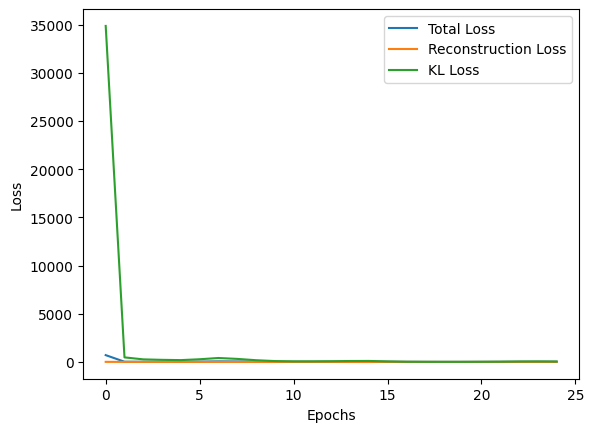

In [23]:
plt.plot(loss_list[1:], label='Total Loss')
plt.plot(recon_loss_list[1:], label='Reconstruction Loss')
plt.plot([l * kl_weight for l in kl_loss_list][1:], label='KL Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

In [26]:
HR, LR = val_dataset.get_samples(10)
SR = model.sample(LR)

In [27]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')

c:\UniProgramme\anaconda3\envs\ISL\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


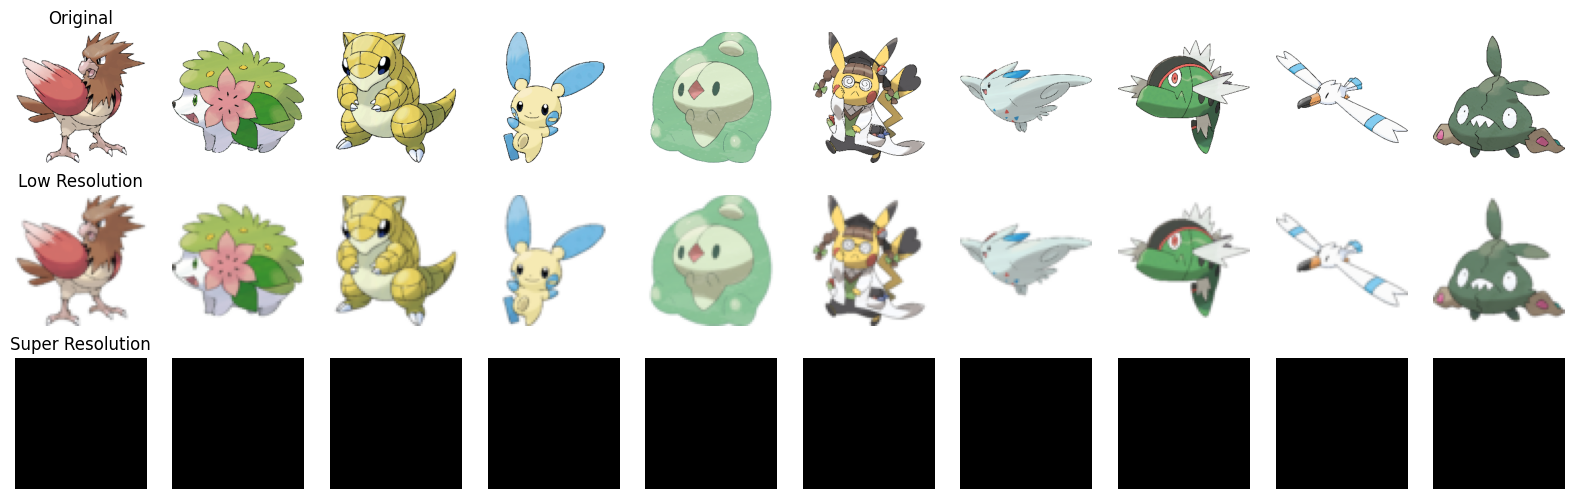

In [28]:
show_image(HR, LR, SR, 10)

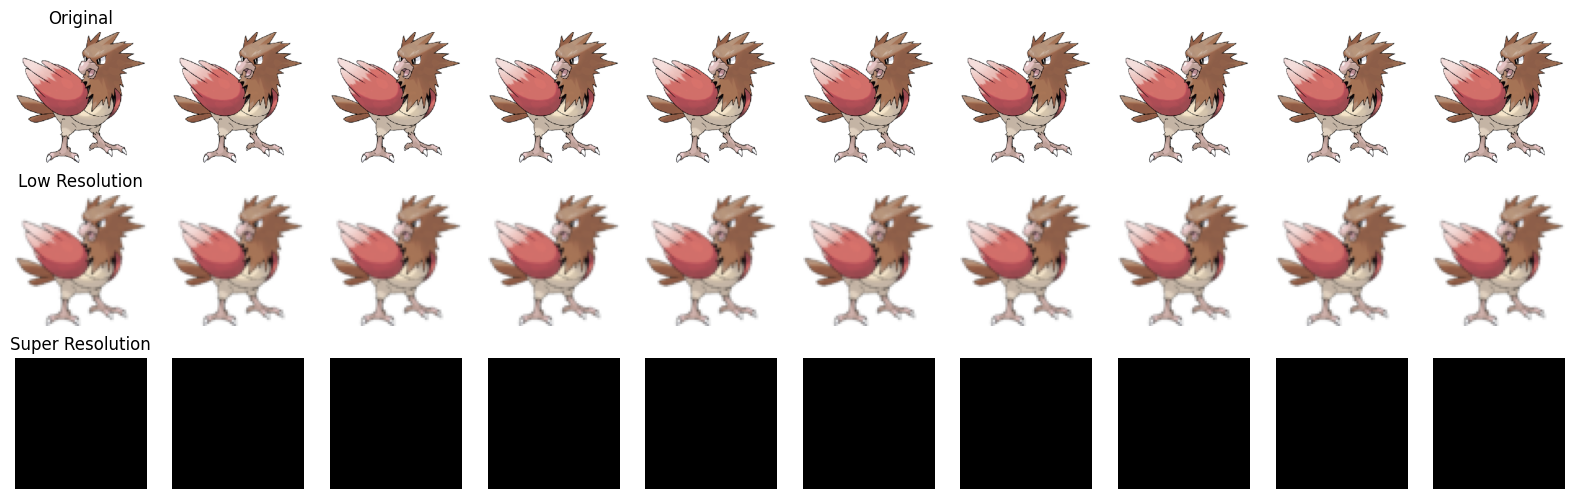

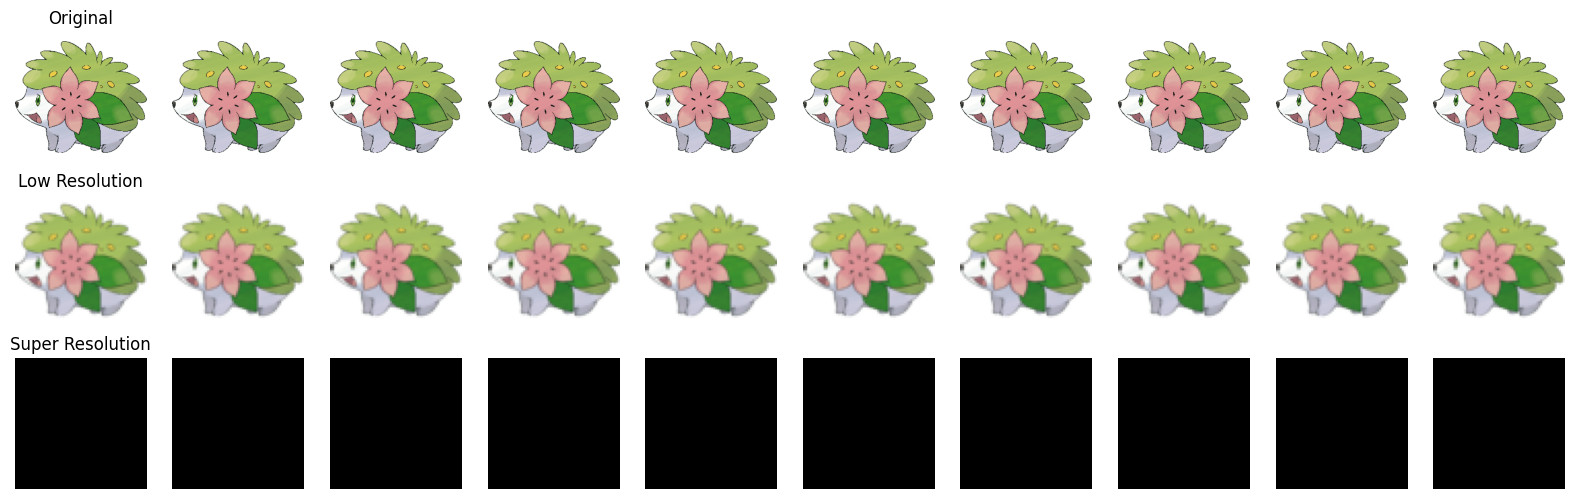

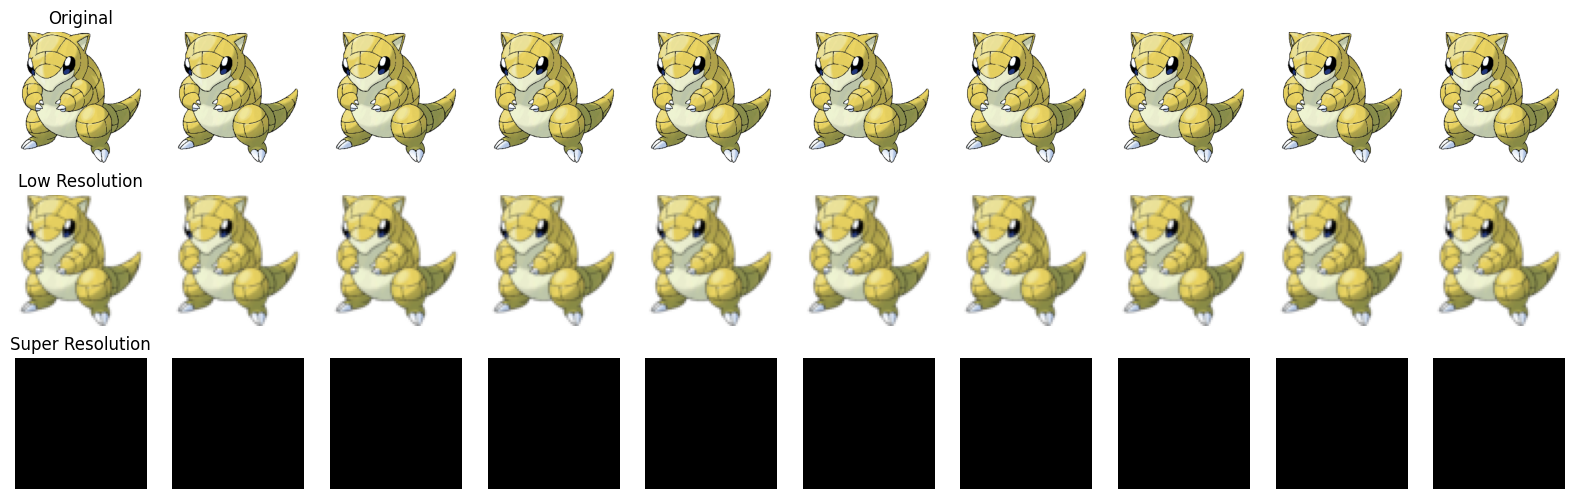

In [29]:
n_samp = 3

for i in range(n_samp):
    reference = HR[i]
    reference = reference.repeat(batch_size, 1, 1, 1)
    reference_inp = LR[i].unsqueeze(0).repeat(batch_size, 1, 1, 1)
    
    samples = model.sample(reference_inp).detach().cpu()

    show_image(reference, reference_inp, samples, 10)

In [ ]:
psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)